    obec_A  spolu  mimo_obce  v_obci  mimo_obce_percent  v_obci_percent  \
0   507300    115         99    16.0          86.086957       13.913043   
1   507393     75         67     8.0          89.333333       10.666667   
2   507407     46         42     4.0          91.304348        8.695652   
3   510262   7844       1331  6513.0          16.968383       83.031617   
4   510271    146        138     8.0          94.520548        5.479452   
..     ...    ...        ...     ...                ...             ...   
76  511196    336        251    85.0          74.702381       25.297619   
77  511200    118        101    17.0          85.593220       14.406780   
78  556807     19         15     4.0          78.947368       21.052632   
79  558281    243        195    48.0          80.246914       19.753086   
80  580287    367        326    41.0          88.828338       11.171662   

    independence  
0          False  
1          False  
2          False  
3           True  
4   

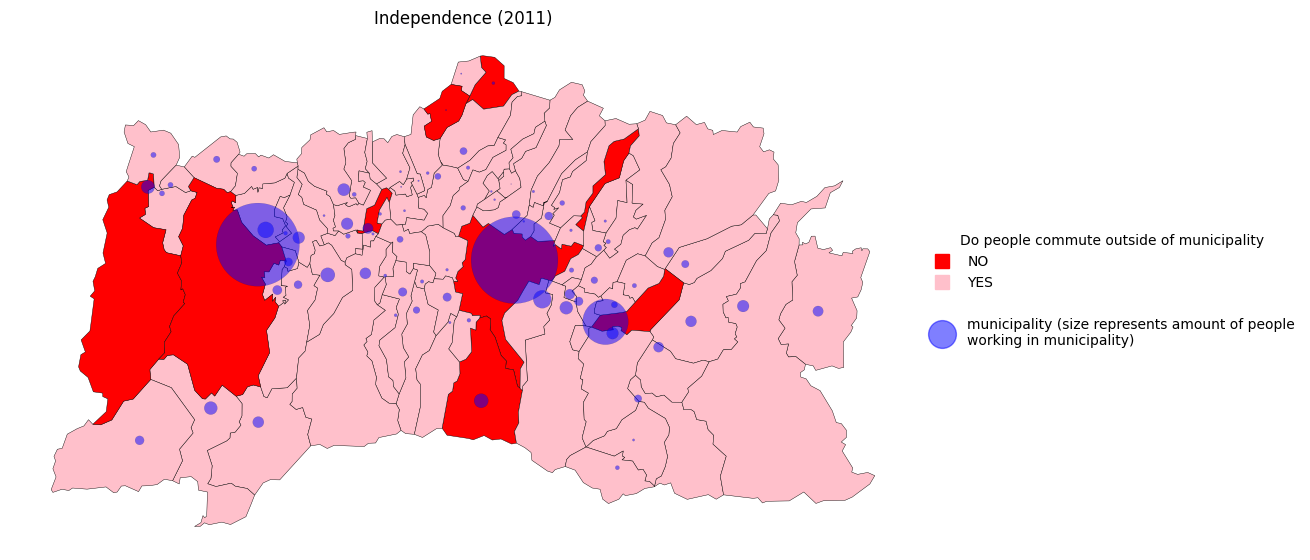

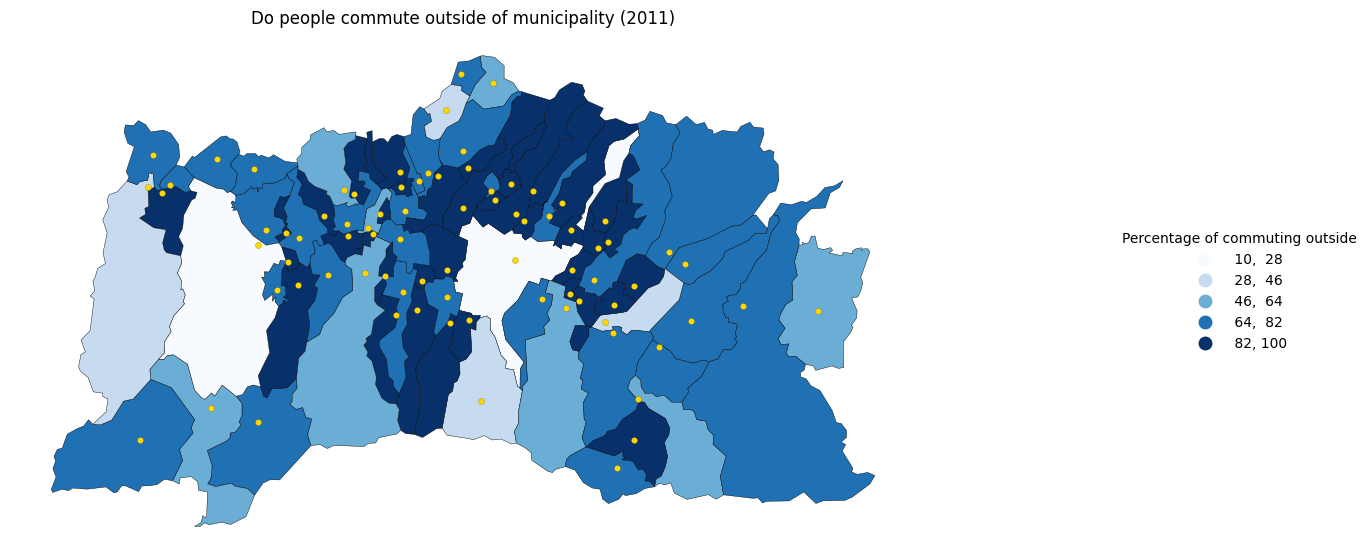

In [81]:
import geopandas as gpd
import pandas as pd
import numpy as np
# from numpy import infinity
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

help = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")
commute = pd.read_csv(r"../data/dochadzka_zamestnanie_sodb_2011.csv", sep=";")
obce = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")
map2 = gpd.read_file(r"../data/geo/liptov.shp")
map2.drop(columns = ["DOW", "FACC", "IDN3", "NM3", "IDN2", "NM2", "NUTS1", "NUTS1_CODE", "NUTS2", "NUTS2_CODE", "NUTS3", "NUTS3_CODE", "LAU1", "LAU1_CODE", "LAU2", "LAU2_CODE", "VYMERA", "Shape_Area", "Shape_Leng"], inplace = True)
commute = (commute).rename(columns = {"obecA": "obec_A", "obecB": "obec_B", "POCET": "pocet_11"})


help[["obecA", "obecB"]] = help[["obecA", "obecB"]].astype(str)
help["pocet"] = help["pocet"].astype(int)
help["flow"] = help[["obecA", "obecB"]].agg("-".join, axis = 1)

commute[["obec_A", "obec_B"]] = commute[["obec_A", "obec_B"]].astype(str)
commute["pocet_11"] = commute["pocet_11"].astype(int)
commute["flow"] = commute[["obec_A", "obec_B"]].agg("-".join, axis = 1)

map2["IDN4"] = map2["IDN4"].astype(str)
obce["kod"] = obce["kod"].astype(str)
unique_obce = map2["IDN4"].apply(str).tolist()
commute = commute[commute["Periodicita dochadzky"] == 1]
commute = commute[commute["obec_A"].isin(unique_obce) & commute["obec_B"].isin(unique_obce)]
# print(commute)


all = (
    commute
    .groupby("obec_A", group_keys = False)["pocet_11"]
    .sum()
)
outer = (
    commute[commute["obec_A"] != commute["obec_B"]]
    .groupby("obec_A", group_keys=False)["pocet_11"]
    .sum()
)
inter = (
    commute[commute["obec_A"] == commute["obec_B"]]
    .groupby("obec_A", group_keys=False)["pocet_11"]
    .sum()
)

all_df = all.reset_index().rename(columns = {"pocet_11": "spolu"})
inter_df = inter.reset_index().rename(columns = {"pocet_11": "v_obci"})
outer_df = outer.reset_index().rename(columns = {"pocet_11": "mimo_obce"})

table = all_df.merge(
    outer_df.merge(
    inter_df,
    on = "obec_A",
    how = "left"
), on = "obec_A", how = "left").fillna(0)
# print(outer.head())
# print(inter)

table["mimo_obce_percent"] = table["mimo_obce"]/table["spolu"]*100
table["v_obci_percent"] = table["v_obci"]/table["spolu"]*100
table["independence"] = table["v_obci"] > table["mimo_obce"]
print(table)
tablemap2 = map2.merge(
    table,
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
)

# print(tablemap2)
color_dict_i = {True: "red", False: "pink"}
# print(obce.head())
comm = (commute.groupby("obec_B", group_keys = False)["pocet_11"].sum())
comm = comm.reset_index()
# print(comm.head())
obce_comm = obce.merge(
    comm,
    left_on = "kod",
    right_on = "obec_B",
    how = "left"
)
# print(tablemap2.head())

obce_gdf = gpd.GeoDataFrame(
    obce_comm,
    geometry=[Point(xy) for xy in zip(obce["x"], obce["y"])],
    crs="EPSG:5514"
)
# print(obce_gdf.head())

# ---------------- DOES THE MAJORITY OF PEOPLE IN WORKING AGE COMMUTE OUTSIDE OF MUNICIPALITY ---------------- 
plt.figure(figsize = (11.69, 8.27))
# plt.subplot(2, 1, 1)
tablemap2.plot(
    ax = plt.gca(),
    color = tablemap2["independence"].map(color_dict_i),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "blue",
    markersize = obce_gdf["pocet_11"]/obce_gdf["pocet_11"].idxmax()*20,
    alpha = 0.5,
    edgecolor = "black",
    linewidth = 0.1
)
handles_i = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = "NO" if key else "YES"
        )
        for key, color in color_dict_i.items()
]
handles_i.append(
    plt.Line2D(
        [0], [0],
        marker = "",
        color = "white",
        markersize = 20,
        linestyle = "None",
        label = ""
    )
)
handles_i.append(
    plt.Line2D(
        [0], [0],
        marker = "o",
        color = "blue",
        alpha = 0.5,
        markersize = 20,
        linestyle = "None",
        label = "municipality (size represents amount of people\nworking in municipality)"
    )
)
plt.legend(
    handles = handles_i,
    title = "Do people commute outside of municipality",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("Independence (2011)")
plt.axis(False)
plt.savefig("../result_maps/autonomy/LM_RK_autonomy_2011_binary.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()
# ---------------- WHICH PERCENT OF PEOPLE DOES COMMUTE OUTSIDE OF MUNICIPALITY ---------------- 
plt.figure(figsize = (11.69, 8.27))
tablemap2["interval"] = pd.cut(tablemap2["mimo_obce_percent"], bins = 5, labels = False)
# plt.subplot(2, 1, 2)
tablemap2.plot(
    ax = plt.gca(),
    column = "mimo_obce_percent",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Percentage of commuting outside",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Do people commute outside of municipality (2011)")
plt.axis(False)
plt.savefig("../result_maps/autonomy/LM_RK_autonomy_2011.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

     IDN4                NM4  \
0  507300          Ivachnová   
1  507393             Konská   
2  507407              Turík   
3  510262  Liptovský Mikuláš   
4  510271         Beňadiková   

                                            geometry  obec_A  spolu  \
0  POLYGON Z ((-394781.2 -1189720.44 0, -394660.5...  507300    115   
1  POLYGON Z ((-370472.37 -1183214.32 0, -369895....  507393     75   
2  POLYGON Z ((-399306.99 -1184736.45 0, -398962....  507407     46   
3  MULTIPOLYGON Z (((-384549.42 -1188431.31 0, -3...  510262   7844   
4  POLYGON Z ((-373683.9 -1192066.05 0, -374163.7...  510271    146   

   mimo_obce  v_obci  mimo_obce_percent  v_obci_percent  independence  \
0         99    16.0          86.086957       13.913043         False   
1         67     8.0          89.333333       10.666667         False   
2         42     4.0          91.304348        8.695652         False   
3       1331  6513.0          16.968383       83.031617          True   
4        138   

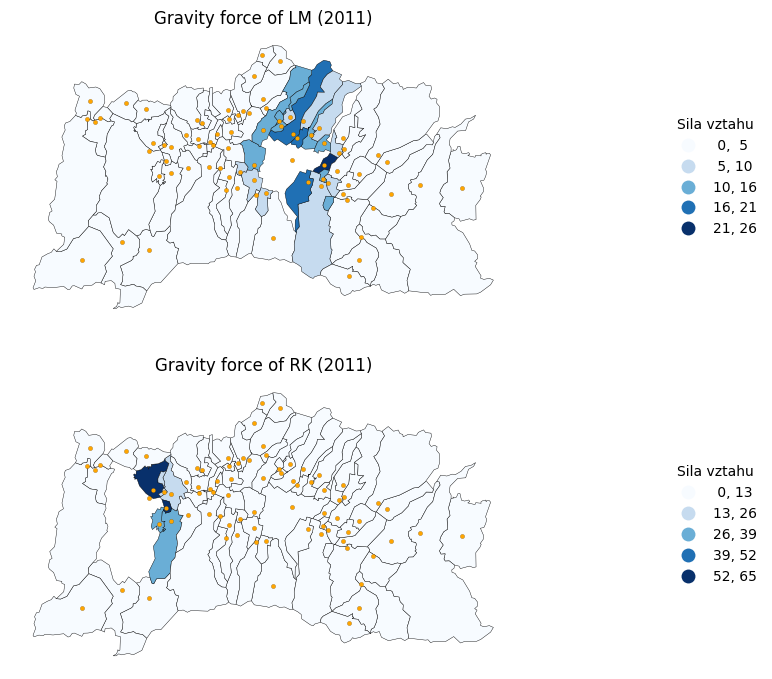

In [ ]:
distance = pd.read_csv(r"../data/vzdialenost_obce.csv", sep = ";")
# print(distance)
distance[["obec_id", "mesto_id"]] = distance[["obec_id", "mesto_id"]].astype(str)
# distance["flow"] = distance[["obec_id", "mesto_id"]].agg("-".join, axis = 1)
distance.drop(columns = {"pocet_dochadzajucich"})
# print(distance.head())
print(tablemap2.head())
dist = tablemap2.merge(
    distance,
    left_on = "obec_A",
    right_on = "obec_id",
    how = "right" 
)
dist = dist[dist["obec_id"] != dist["mesto_id"]]

# print(dist.head())
dist["strength"] = ((dist["pocet_dochadzajucich"]/dist["spolu"]*100)/dist["vzdialenost_km"]**2)*10
# dist.to_csv("../data/test1.csv")
dist_lm = (
    dist[dist["mesto_id"] == "510262"]
).replace(np.inf, 0, inplace = False)
dist_rk = (
    dist[dist["mesto_id"] == "510998"]
).replace(np.inf, 0, inplace = False)
# print(dist_rk)
plt.figure(figsize = (11.69, 8.27))
# ------------------------------ Gravity force of LM ------------------------------
plt.subplot(2, 1, 1)
dist_lm["interval"] = pd.cut(dist_lm["strength"], bins = 5, labels = False)
dist_lm.plot(
    ax = plt.gca(),
    column = "strength",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Gravity force of LM (2011)")
plt.axis(False)

# ------------------------------ Gravity force of RK ------------------------------
plt.subplot(2, 1, 2)
dist_rk["interval"] = pd.cut(dist_rk["strength"], bins = 5, labels = False)
dist_rk.plot(
    ax = plt.gca(),
    column = "strength",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Gravity force of RK (2011)")
plt.axis(False)
plt.savefig("../result_maps/gravity/LM_RK_gravity_2011.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

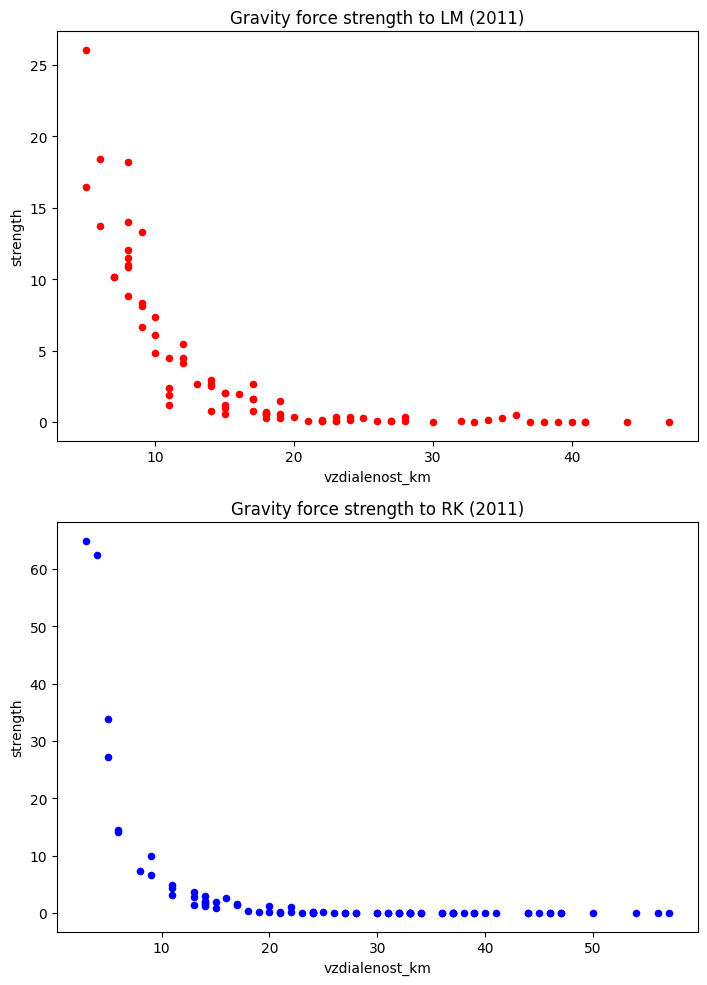

In [89]:
plt.figure(figsize = (8.27, 11.69))

plt.subplot(2, 1, 1)
dist_lm.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "red")
plt.title("Gravity force strength to LM (2011)")
plt.subplot(2, 1, 2)

dist_rk.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "blue")

plt.title("Gravity force strength to RK (2011)")
plt.savefig("../result_maps/gravity/LM_RK_gravity_2011_plot.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

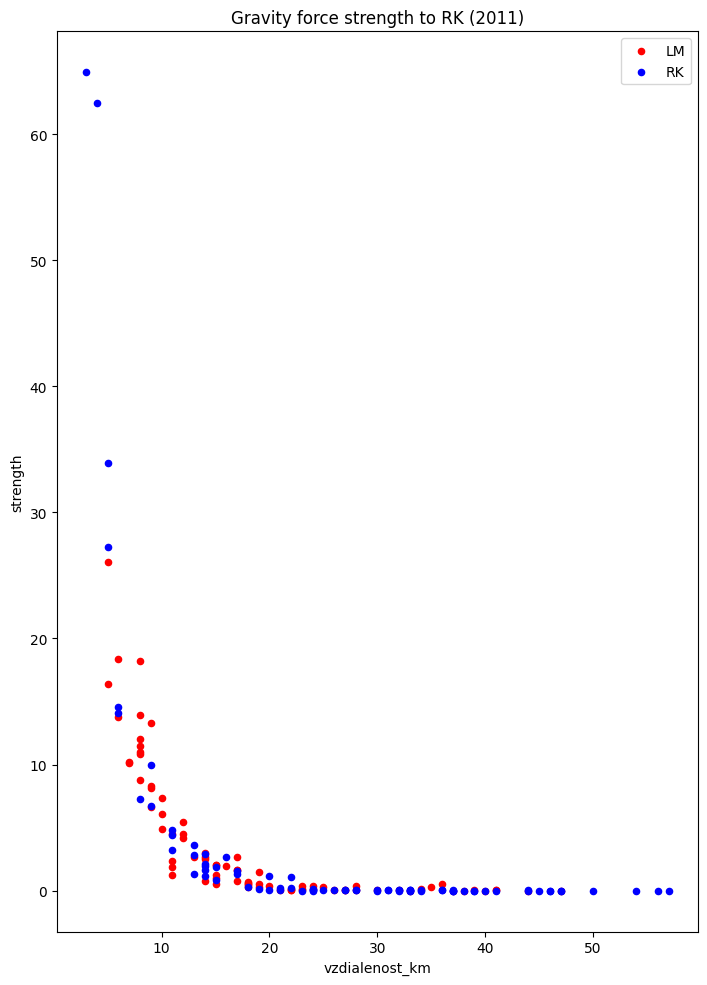

In [90]:
plt.figure(figsize = (8.27, 11.69))

dist_lm.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "red", label = "LM")
plt.title("Gravity force strength to LM (2011)")

dist_rk.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "blue", label = "RK")
plt.title("Gravity force strength to RK (2011)")
plt.savefig("../result_maps/gravity/LM_RK_gravity_2011_plot_both.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

In [84]:
commute1 = commute.merge(
    map2,
    left_on = "obec_A",
    right_on = "IDN4",
    how = "right"
).rename(columns = {"NM4": "obecA_nazov"})
commuting = commute1.merge(
    map2,
    left_on = "obec_B",
    right_on = "IDN4",
    how = "right"
).rename(columns = {"NM4": "obecB_nazov"})
# print(commute1.head())
print(commuting.head())

   obec_A  obec_B  Periodicita dochadzky  pocet_11           flow  IDN4_x  \
0  507300  507300                      1        16  507300-507300  507300   
1  510629  507300                      1         1  510629-507300  510629   
2  510742  507300                      1         1  510742-507300  510742   
3  510823  507300                      1         2  510823-507300  510823   
4  510998  507300                      1         6  510998-507300  510998   

        obecA_nazov                                         geometry_x  \
0         Ivachnová  POLYGON Z ((-394781.2 -1189720.44 0, -394660.5...   
1   Liptovská Lúžna  POLYGON Z ((-399945.59 -1203614.12 0, -400380....   
2  Liptovský Michal  POLYGON Z ((-393349.29 -1189786.26 0, -392826....   
3           Ludrová  POLYGON Z ((-400897.89 -1192465.08 0, -401073....   
4        Ružomberok  POLYGON Z ((-406385.13 -1186159.31 0, -406079....   

   IDN4_y obecB_nazov                                         geometry_y  
0  507300   Ivach

In [85]:
# Most popular destinations (part 1)

# commuting = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")
map = gpd.read_file(r"../data/geo/liptov.shp")
okresy = gpd.read_file(r"../data/geo/liptov_okresy.shp")


# commuting[["obecA", "obecB"]] = commuting[["obecA", "obecB"]].astype(str)
map["IDN4"] = map["IDN4"].astype(str)

most_popular = (
    commuting[commuting["obec_A"] != commuting["obec_B"]]
    .groupby("obec_A", group_keys = False)[["obec_A", "obec_B", "obecB_nazov", "pocet_11"]]
    .apply(lambda x: x.loc[x["pocet_11"].idxmax()])
    .reset_index(drop = True)
)

result = map.merge(
    most_popular[["obec_A", "obec_B", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest = result["obecB_nazov"].unique()
colors = plt.cm.tab20b(np.linspace(0, 1, len(unique_dest)))
color_dict = dict(zip(unique_dest, colors))

most_popular2 = (
    commuting
    .groupby("obec_A", group_keys = False)[["obec_A", "obec_B", "obecB_nazov", "pocet_11"]]
    .apply(lambda x: x.loc[x["pocet_11"].idxmax()])
    .reset_index(drop = True)
)

result2 = map.merge(
    most_popular2[["obec_A", "obec_B", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest2 = result2["obecB_nazov"].unique()
colors2 = plt.cm.tab20b(np.linspace(0, 1, len(unique_dest2)))
color_dict2 = dict(zip(unique_dest2, colors2))


second_popular_75 = (
    commuting[commuting["obec_A"] != commuting["obec_B"]]
    .groupby("obec_A", group_keys = False)[["obec_A", "obec_B", "obecB_nazov", "pocet_11"]]
    .apply(lambda x: x.nlargest(2, "pocet_11").iloc[-1] if len(x) > 1 and x.nlargest(2, "pocet_11")["pocet_11"].iloc[1] >= x.nlargest(2, "pocet_11")["pocet_11"].iloc[0] * 0.75 else None)
    .reset_index(drop=True)
).dropna()
result3 = map.merge(
    second_popular_75[["obec_A", "obec_B", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
).rename(columns = {"IDN4": "kod_start"})
second_dest = result3["obecB_nazov"].unique()
colors3 = plt.cm.tab20b(np.linspace(0, 1, len(second_dest)))
color_dict3 = dict(zip(second_dest, colors3))

second_popular_50 = (
    commuting[commuting["obec_A"] != commuting["obec_B"]]
    .groupby("obec_A", group_keys = False)[["obec_A", "obec_B", "obecB_nazov", "pocet_11"]]
    .apply(lambda x: x.nlargest(2, "pocet_11").iloc[-1] if len(x) > 1 and x.nlargest(2, "pocet_11")["pocet_11"].iloc[1] >= x.nlargest(2, "pocet_11")["pocet_11"].iloc[0] * 0.5 else None)
    .reset_index(drop=True)
).dropna()
result4 = map.merge(
    second_popular_50[["obec_A", "obec_B", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
).rename(columns = {"IDN4": "kod_start"})
second_dest_50 = result4["obecB_nazov"].unique()
colors4 = plt.cm.tab20b(np.linspace(0, 1, len(second_dest_50)))
color_dict4 = dict(zip(second_dest_50, colors4))

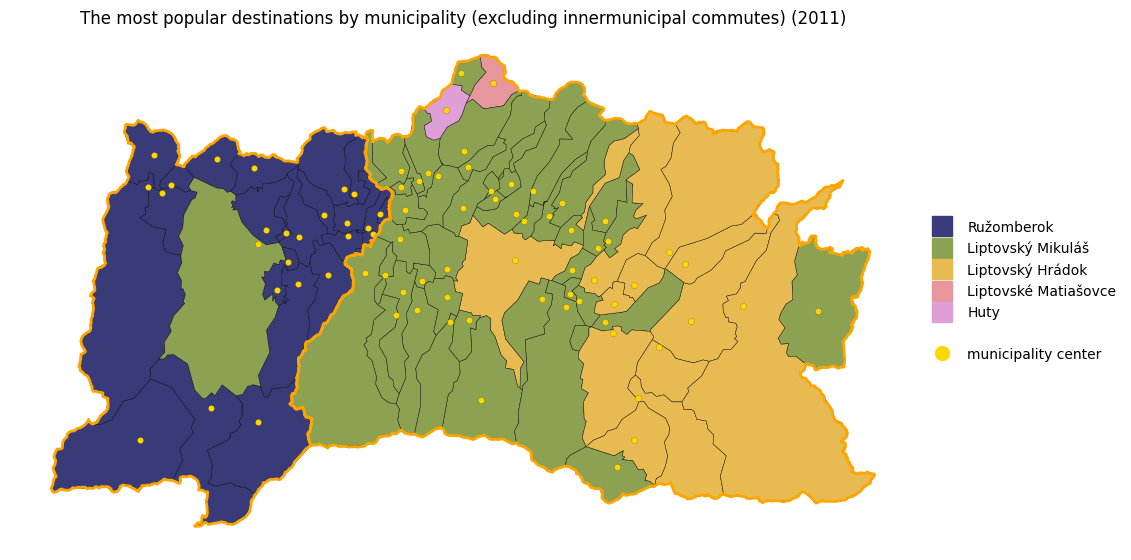

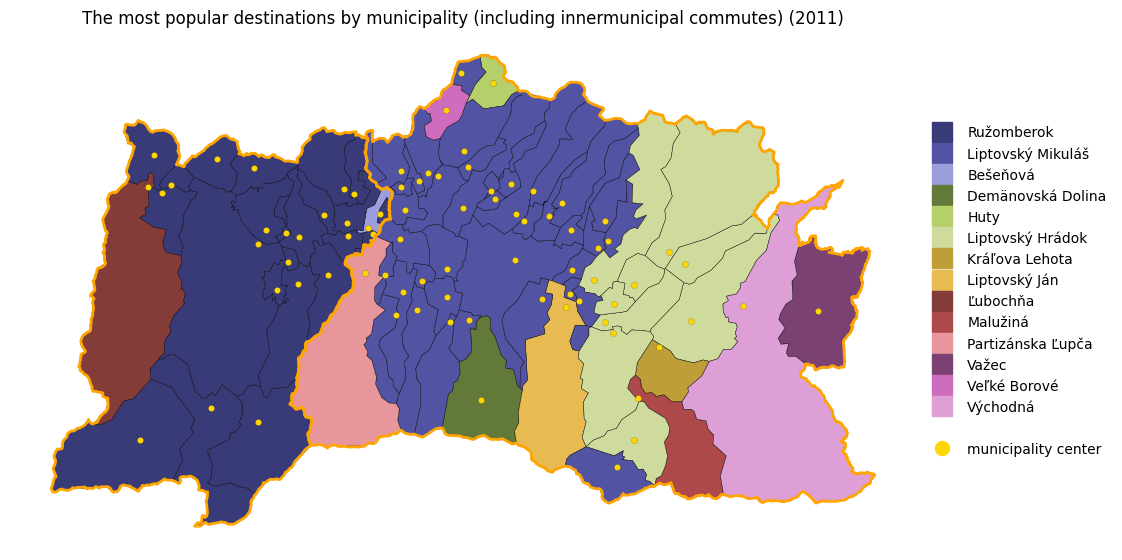

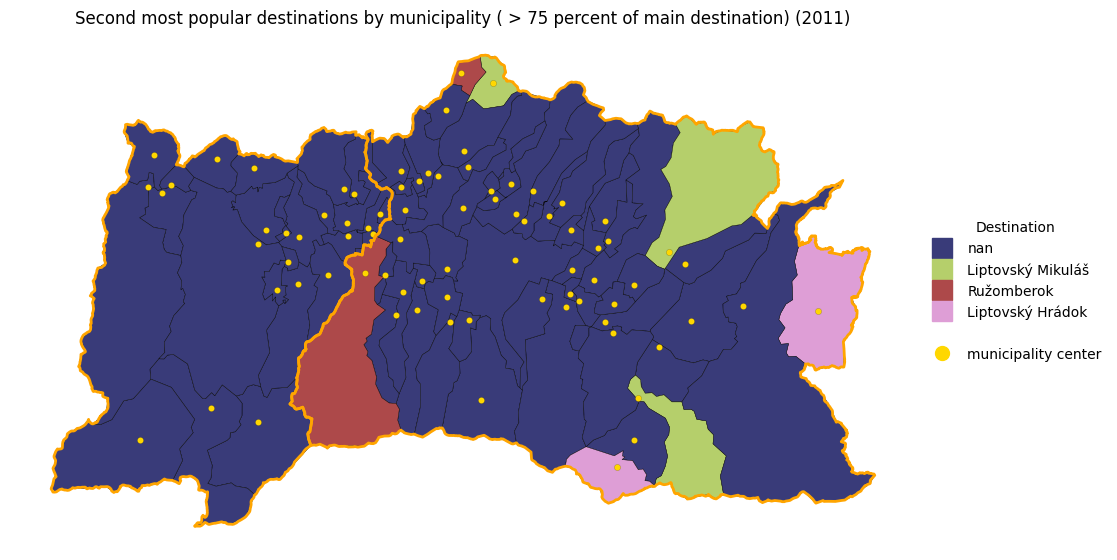

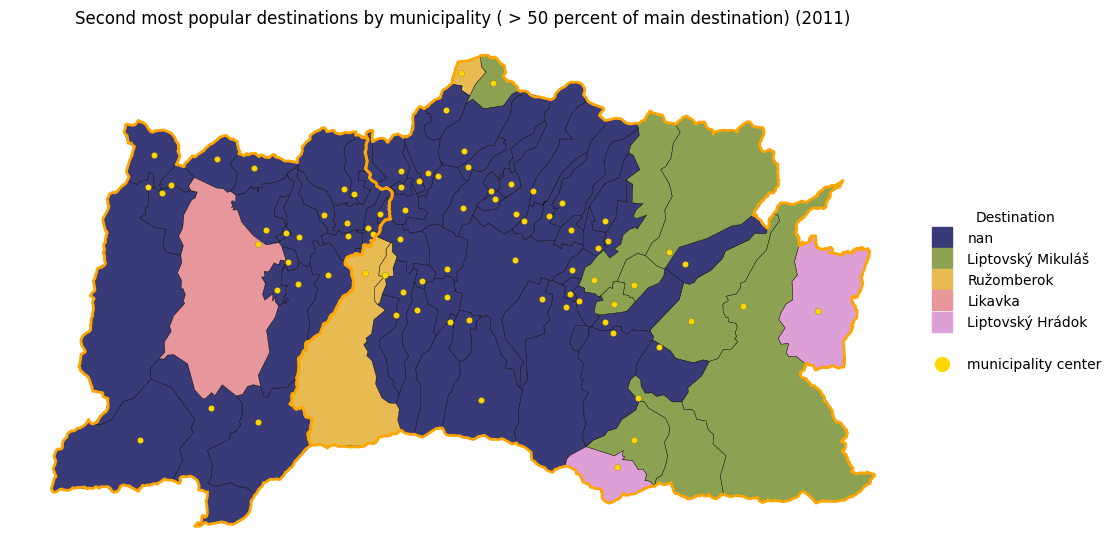

In [86]:
# (part 2)

plt.figure(figsize = (11.69, 8.27))
result.plot(
    ax = plt.gca(),
    color = [color_dict.get(d, "lightgray") for d in result["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)
handles = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 15,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict.items()
]
handles.append(
    plt.Line2D(
        [0], [0],
        marker = "",
        color = "white",
        markersize = 20,
        linestyle = "None",
        label = ""
    )
)
handles.append(
    plt.Line2D(
        [0], [0],
        marker = "o",
        color = "gold",
        markersize = 10,
        linestyle = "None",
        label = "municipality center"
    )
)
plt.legend(
    handles = handles,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("The most popular destinations by municipality (excluding innermunicipal commutes) (2011)")

plt.axis(False)

plt.savefig("../result_maps/popular/2011_most_popular.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()



plt.figure(figsize = (11.69, 8.27))
result2.plot(
    ax = plt.gca(),
    color = [color_dict2.get(d, "lightgray") for d in result2["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)
handles2 = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 15,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict2.items()
]
handles2.append(
    plt.Line2D(
        [0], [0],
        marker = "",
        color = "white",
        markersize = 20,
        linestyle = "None",
        label = ""
    )
)
handles2.append(
    plt.Line2D(
        [0], [0],
        marker = "o",
        color = "gold",
        markersize = 10,
        linestyle = "None",
        label = "municipality center"
    )
)
plt.legend(
    handles = handles2,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("The most popular destinations by municipality (including innermunicipal commutes) (2011)")

plt.axis(False)

plt.savefig("../result_maps/popular/2011_most_popular_all.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()


plt.figure(figsize = (11.69, 8.27))
result3.plot(
    ax = plt.gca(),
    color = [color_dict3.get(d, "lightgray") for d in result3["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)
handles3 = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 15,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict3.items()
]
handles3.append(
    plt.Line2D(
        [0], [0],
        marker = "",
        color = "white",
        markersize = 20,
        linestyle = "None",
        label = ""
    )
)
handles3.append(
    plt.Line2D(
        [0], [0],
        marker = "o",
        color = "gold",
        markersize = 10,
        linestyle = "None",
        label = "municipality center"
    )
)
plt.legend(
    handles = handles3,
    title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False,
    # labelspacing = 1.25
)
plt.title("Second most popular destinations by municipality ( > 75 percent of main destination) (2011)")

plt.axis(False)
# plt.suptitle("Daily commuting patterns in Liptov region in 2021")
plt.savefig("../result_maps/popular/2011_second_most_popular_75.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()


plt.figure(figsize = (11.69, 8.27))
result4.plot(
    ax = plt.gca(),
    color = [color_dict4.get(d, "lightgray") for d in result4["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)
handles4 = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 15,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict4.items()
]
handles4.append(
    plt.Line2D(
        [0], [0],
        marker = "",
        color = "white",
        markersize = 20,
        linestyle = "None",
        label = ""
    )
)
handles4.append(
    plt.Line2D(
        [0], [0],
        marker = "o",
        color = "gold",
        markersize = 10,
        linestyle = "None",
        label = "municipality center"
    )
)
plt.legend(
    handles = handles4,
    title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False,
    # labelspacing = 1.25
)
plt.title("Second most popular destinations by municipality ( > 50 percent of main destination) (2011)")

plt.axis(False)
# plt.suptitle("Daily commuting patterns in Liptov region in 2021")
plt.savefig("../result_maps/popular/2011_second_most_popular_50.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

   obec_A  obec_B  Periodicita dochadzky  pocet_11           flow  IDN4_x  \
0  507300  507300                      1        16  507300-507300  507300   
1  510629  507300                      1         1  510629-507300  510629   
2  510742  507300                      1         1  510742-507300  510742   
3  510823  507300                      1         2  510823-507300  510823   
4  510998  507300                      1         6  510998-507300  510998   

        obecA_nazov                                         geometry_x  \
0         Ivachnová  POLYGON Z ((-394781.2 -1189720.44 0, -394660.5...   
1   Liptovská Lúžna  POLYGON Z ((-399945.59 -1203614.12 0, -400380....   
2  Liptovský Michal  POLYGON Z ((-393349.29 -1189786.26 0, -392826....   
3           Ludrová  POLYGON Z ((-400897.89 -1192465.08 0, -401073....   
4        Ružomberok  POLYGON Z ((-406385.13 -1186159.31 0, -406079....   

   IDN4_y obecB_nazov                                         geometry_y  \
0  507300   Ivac

<Figure size 827x1169 with 0 Axes>

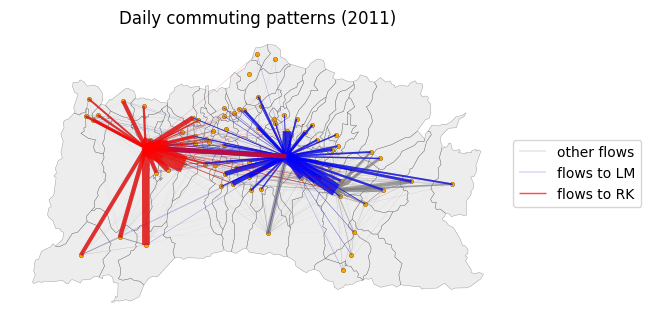

In [87]:
import geopandas as gpd
import pandas as pd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

obce = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")

commuting["obec_A"] = commuting["obec_A"].astype(str)
commuting["obec_B"] = commuting["obec_B"].astype(str)
obce["kod"] = obce["kod"].astype(str)
commuting = commuting.merge(
    obce[["kod", "x", "y"]],
    left_on = "obec_A",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "start_x", "y": "start_y", "kod": "kod_start"})

commuting = commuting.merge(
    obce[["kod", "x", "y"]],
    left_on = "obec_B",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "end_x", "y": "end_y", "kod": "kod_dest"})
commuting_gdf = gpd.GeoDataFrame(
    commuting,
    geometry=[Point(xy) for xy in zip(commuting["start_x"], commuting["start_y"])],
    crs="EPSG:5514"
)
print(commuting_gdf.head())

background = gpd.read_file(r"../data/geo/liptov.shp")
# flows_selected = f[f["kod_dest"].isin(["510262", "510998"])].copy()

# flows_selected["geometry"] = flows_selected.apply(
#     lambda row: LineString([(row["start_x"], row["start_y"]), (row["end_x"], row["end_y"])]),
#     axis = 1
# )
commuting["geometry"] = commuting.apply(
    lambda row: LineString([(row["start_x"], row["start_y"]), (row["end_x"], row["end_y"])]),
    axis = 1
)
line_gdf = gpd.GeoDataFrame(commuting, geometry = "geometry", crs="EPSG:5514")

flows_510262 = line_gdf[line_gdf["kod_dest"] == "510262"]
flows_510998 = line_gdf[line_gdf["kod_dest"] == "510998"]
flows_other = line_gdf
plt.figure(figsize = (8.27, 11.69))

ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)
flows_other.plot(
    ax = ax,
    linewidth = flows_other["pocet_11"]/50,
    alpha = 0.7,
    color = "grey",
    label = "other flows"
)
flows_510262.plot(
    ax = ax,
    linewidth = flows_510262["pocet_11"]/50,
    alpha = 0.7,
    color = "blue",
    label = "flows to LM"
)

flows_510998.plot(
    ax = ax,
    linewidth = flows_510998["pocet_11"]/50,
    alpha = 0.7,
    color = "red",
    label = "flows to RK"
)


# flows_other.plot(
#     ax = ax,
#     linewidth = flows_other["pocet"] / flows_other["pocet"].max()*100,
#     alpha = 0.7,
#     color = "grey",
#     label = "other flows"
# )
# flows_510262.plot(
#     ax = ax,
#     linewidth = flows_510262["pocet"] / flows_510262["pocet"].max()*100,
#     alpha = 0.7,
#     color = "blue",
#     label = "flows to LM"
# )

# flows_510998.plot(
#     ax = ax,
#     linewidth = flows_510998["pocet"] / flows_510998["pocet"].max()*100,
#     alpha = 0.7,
#     color = "red",
#     label = "flows to RK"
# )

obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns (2011)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis(False)

plt.grid(False)

obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns (2011)")
plt.axis(False)
plt.grid(False)

plt.savefig("../result_maps/flows/LM_RK_flows_2011.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

<Figure size 827x1169 with 0 Axes>

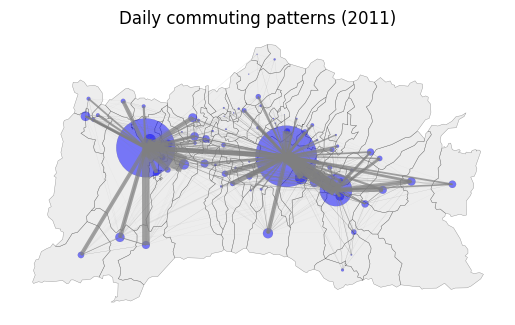

In [88]:
plt.figure(figsize = (8.27, 11.69))

ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)

flows_other.plot(
    ax = ax,
    linewidth = flows_other["pocet_11"]/50,
    alpha = 0.7,
    color = "grey",
    label = "other flows"
)
obce_gdf.plot(
    ax = ax,
    color = "blue",
    markersize = obce_gdf["pocet_11"]/obce_gdf["pocet_11"].idxmax()*10,
    alpha = 0.5,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Daily commuting patterns (2011)")
plt.axis(False)
plt.grid(False)

plt.savefig("../result_maps/flows/all_LM_RK_flows_2011.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()
